test for 2D simulation

Ornstein-Uhlenbeck process:
Xn - Xn-1 = theta*(mu-y)* dt + sigma* noise

drift term = theta*(mu-y)

diffusion term = sigma * noise

2D simulation:
Xn - Xn-1 = D(Xn-1, Yn-1)F(Xn-1, Yn-1)dt - (2Ddt)^1/2 N(0,1)

drift term = D(r)F(r)* dt

diffusion term = np.sqrt(2Ddt)* noise


In [1]:
import math
import numpy as np                  # numpy
import pandas as pd
import seaborn as sns               # for probability distribution

import matplotlib.pyplot as plt     # pyplot
from matplotlib import cm           # colormap
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm, LogNorm


plt.rcParams["figure.figsize"] = (20,10) #make graph larger

In [2]:
#cone well
def DiffCoef_Para(x):
    D = D_out * np.ones(np.shape(x))
    D[a>np.absolute(x)] = (D_out - D_in) * (x[a>np.absolute(x)]/4) + D_in
    return D
                                            
def Force_Para(x):
    f = np.zeros(np.shape(x))
    f[a>np.absolute(x)] = (-np.sign(x[a>np.absolute(x)]) * 0.25)*3
    return f

def Potential_Para(x):
    V = V_out * np.ones(np.shape(x))
    V[a>np.absolute(x)] = (V_out - V_in) * (x[a>np.absolute(x)]/4) + V_in
    return V
'''
#para well
def DiffCoef_Para(x):
    D = D_out * np.ones(np.shape(x))
    D[a>np.absolute(x)] = (D_out - D_in) * (x[a>np.absolute(x)]**2)/(a**2) + D_in
    return D
    
#need some modifications in higher dimensions simulations
#since force is vector in higher dimensions (for 3D, it should be a 3*3*3 array instead of a list)   
def Force_Para(x): 
    f = np.zeros(np.shape(x))
    f[a>np.absolute(x)] = -(V_out - V_in) * (2*x[a>np.absolute(x)])/(a**2)
    return f

def Potential_Para(x):
    V = V_out * np.ones(np.shape(x))
    V[a>np.absolute(x)] = (V_out-V_in) * (x[a>np.absolute(x)]**2)/(a**2) + V_in
    return V
'''
# Apply periodic boundary condition
# Restrict to [-L, L)
def PeriodicBC(x, L): 
    return (x+L)%(2.0 * L) - L

# cell properties
def bound(x2):      # assume the particle would bounce one times only
    x = x2 - (np.sign(x2) * L)
    x2 = np.sign(x2) * L - x
    return x2
def real_bound(x2): # particle will move from one side to another side of the cell, treat cell as a continious surface
    x = -np.sign(x2)*L + (x2 - np.sign(x2)*L)
    return x

# MSD
# https://stackoverflow.com/questions/34222272/computing-mean-square-displacement-using-python-and-fft
def msd_straight_forward(r):
    shifts = np.arange(len(r))
    msds = np.zeros(shifts.size)    

    for i, shift in enumerate(shifts):
        diffs = r[:-shift if shift else None] - r[shift:]
        sqdist = np.square(diffs).sum(axis=1)
        msds[i] = sqdist.mean()
    return msds
    
def autocorrFFT(x):
  N=len(x)
  F = np.fft.fft(x, n=2*N)  #2*N because of zero-padding
  PSD = F * F.conjugate()
  res = np.fft.ifft(PSD)
  res= (res[:N]).real   #now we have the autocorrelation in convention B
  n=N*np.ones(N)-np.arange(0,N) #divide res(m) by (N-m)
  return res/n #this is the autocorrelation in convention A

def msd_fft(r):
  N=len(r)
  D=np.square(r).sum(axis=1) 
  D=np.append(D,0) 
  S2=sum([autocorrFFT(r[:, i]) for i in range(r.shape[1])])
  Q=2*D.sum()
  S1=np.zeros(N)
  for m in range(N):
      Q=Q-D[m-1]-D[N-m]
      S1[m]=Q/(N-m)
  return S1-2*S2
  

In [3]:
D_out = 1           # diffusivity outside the well
D_in = 0.5        # diffusivity inside the well, impossible to have 0 diffusivity
V_out = 0           # potential energy outside the well
V_in = -4          # potential energy inside the well, from other paper lab data
a = 2               # well size
L = 5               # "cell" size

t_0 = 0             # start time
t_end = 40          # end time
length = 5000       # number of time division
test_number = 2500   # number of protein

t = np.linspace(t_0, t_end, length)
dt = np.mean (np.diff(t))
x_Para = np.zeros((test_number, length))
y_Para = np.zeros((test_number, length))
D_Para = np.zeros((test_number, length))
V_Para = np.zeros((test_number, length))
P_Para = np.zeros((test_number, length))
x_Para_plot = np.zeros((test_number, length))
y_Para_plot = np.zeros((test_number, length))


In [4]:
x_noise = np.random.normal(loc = 0.0, scale = 1.0, size = (test_number, length))*np.sqrt(dt)
y_noise = np.random.normal(loc = 0.0, scale = 1.0, size = (test_number, length))*np.sqrt(dt)

In [5]:
x_Para_plot[:, 0] = PeriodicBC(x_Para[:, 0], L)
y_Para_plot[:, 0] = PeriodicBC(y_Para[:, 0], L)
for j in range(1, length):
    r = np.sqrt((x_Para_plot[:, j-1]**2) + (y_Para_plot[:, j-1]**2))
    x_Para[:,j] = x_Para[:,j-1] + DiffCoef_Para(r) * (x_Para_plot[:, j-1]/a * Force_Para(r)) * dt + \
        np.sqrt(2.0 * DiffCoef_Para(r)) * x_noise[:,j]
    y_Para[:,j] = y_Para[:,j-1] + DiffCoef_Para(r) * (y_Para_plot[:, j-1]/a * Force_Para(r)) * dt + \
        np.sqrt(2.0 * DiffCoef_Para(r)) * y_noise[:,j]
    x_Para_plot[:, j] = PeriodicBC(x_Para[:, j], L)
    y_Para_plot[:, j] = PeriodicBC(y_Para[:, j], L)

# 2D simulation

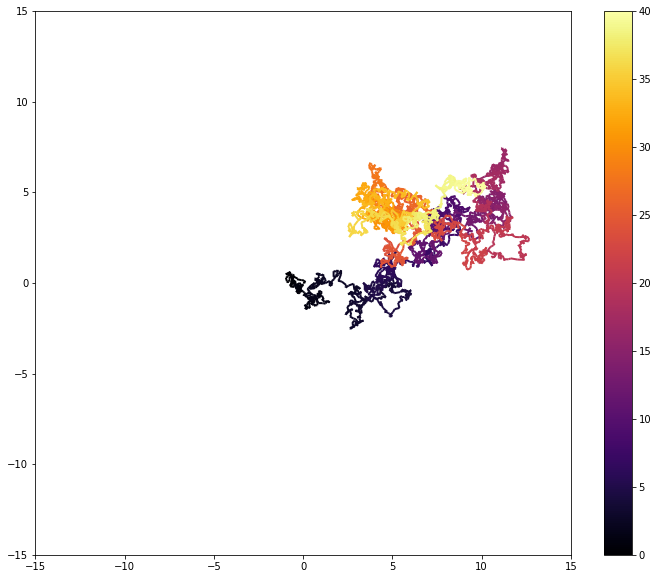

In [6]:
plt.rcParams["figure.figsize"] = (12, 10)

points = np.array([x_Para[0], y_Para[0]]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
fig, ax = plt.subplots()
norm = plt.Normalize(t.min(), t.max())
lc = LineCollection(segments, cmap="inferno", norm=norm)
lc.set_array(t)
lc.set_linewidth(2)
line = ax.add_collection(lc)
plt.colorbar(line, ax=ax)

ax.set_xlim(-15, 15)
ax.set_ylim(-15, 15)
plt.show()

(-5.5, 5.5)

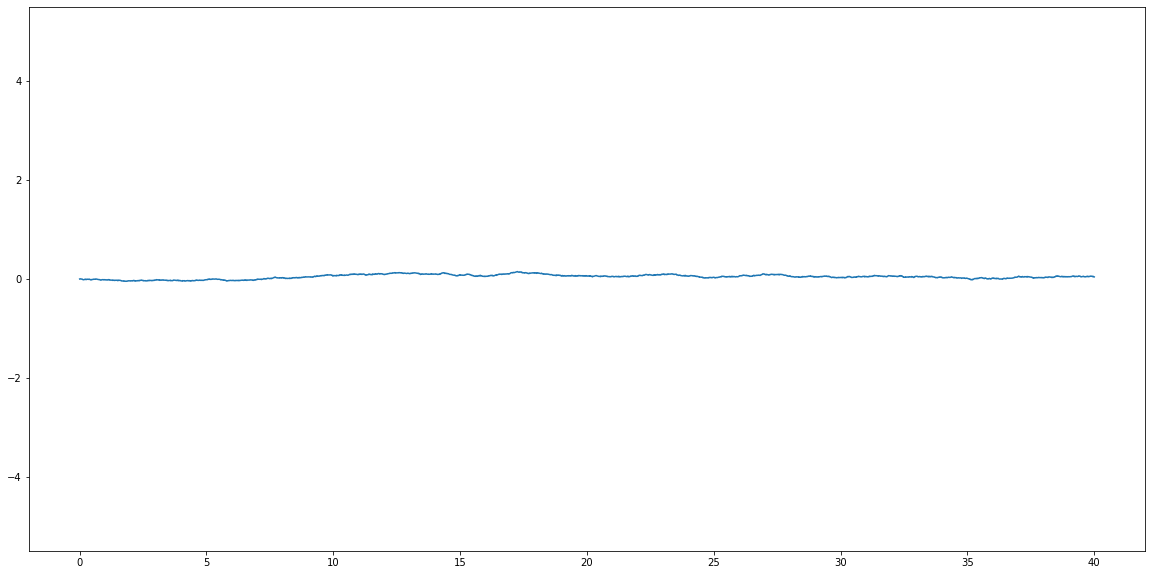

In [7]:
plt.rcParams["figure.figsize"] = (20, 10)

x_Para_mean = np.zeros((1, length))
for i in range(length):
    x_Para_mean[0,i] = x_Para[:, i].mean()

plt.plot(t, x_Para_mean[0,:], label = "para mean")
plt.ylim(-5.5, 5.5)

# Distribution and Prediction

(51,)

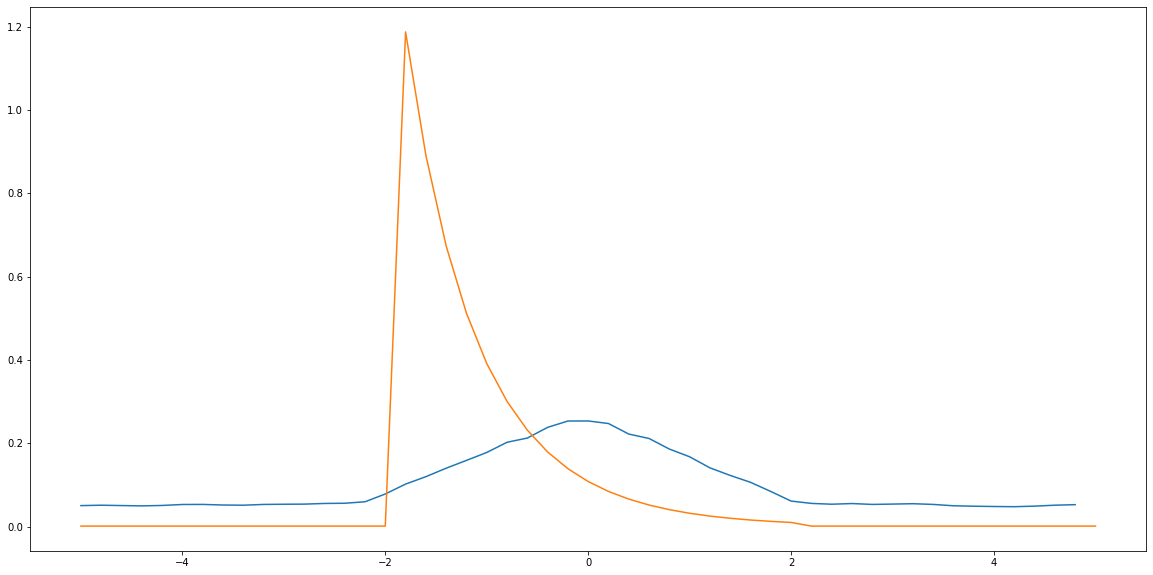

In [8]:
density2d, x_edges, y_edges = np.histogram2d(np.reshape(x_Para_plot[:, 500:4000], -1), np.reshape(y_Para_plot[:, 500:4000], -1), bins=50, density=True)

pdf_predict = np.exp(-Potential_Para(x_edges)) / DiffCoef_Para(x_edges)
pdf_predict = pdf_predict / np.sum(pdf_predict) / (2*L/50)
pdf_simulation = density2d[:, 25] / np.sum(density2d[:, 25]) / (2*L/50)
plt.plot(x_edges[:-1], pdf_simulation)
plt.plot(x_edges, pdf_predict)
np.shape(pdf_predict)

Text(0.5, 0.98, 'x_Para_plot')

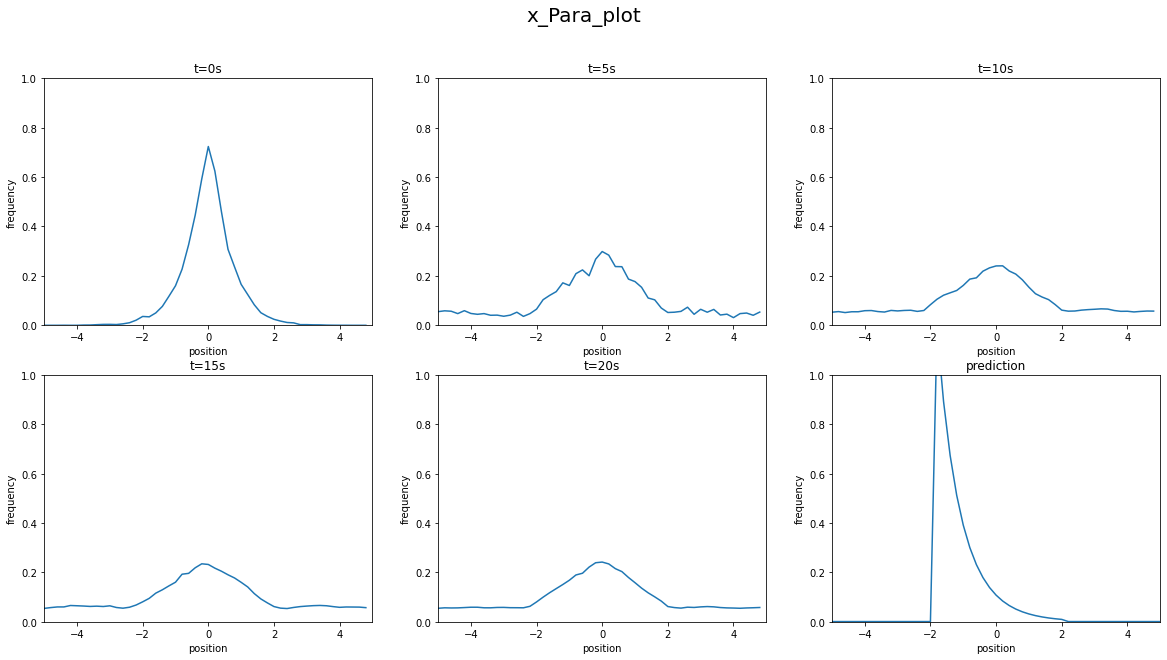

In [9]:
# https://stackoverflow.com/questions/61881175/normed-histogram-y-axis-larger-than-1

plt.rcParams["figure.figsize"] = (20,10)
hist_range = 100

length_t0  = int(length*0.00)
length_t5  = int(length*0.25)
length_t10 = int(length*0.50)
length_t15 = int(length*0.75)
length_t20 = int(length*1.00)

dist_temp_t0, x_edges, y_edges = np.histogram2d(np.reshape(x_Para_plot[:, length_t0:length_t0+hist_range], -1),
    np.reshape(y_Para_plot[:, length_t0:length_t0+hist_range], -1), bins=50, density=True)
dist_temp_t0 = dist_temp_t0[:, 25] / np.sum(dist_temp_t0[:, 25]) / (2*L/50)

dist_temp_t5, x_edges, y_edges = np.histogram2d(np.reshape(x_Para_plot[:, length_t5:length_t5+hist_range], -1),
    np.reshape(y_Para_plot[:, length_t5:length_t5+hist_range], -1), bins=50, density=True)
dist_temp_t5 = dist_temp_t5[:, 25] / np.sum(dist_temp_t5[:, 25]) / (2*L/50)

dist_temp_t10, x_edges, y_edges = np.histogram2d(np.reshape(x_Para_plot[:, length_t10:length_t15], -1),
    np.reshape(y_Para_plot[:, length_t10:length_t15], -1), bins=50, density=True)
dist_temp_t10 = dist_temp_t10[:, 25] / np.sum(dist_temp_t10[:, 25]) / (2*L/50)

dist_temp_t15, x_edges, y_edges = np.histogram2d(np.reshape(x_Para_plot[:, length_t15:length_t20], -1),
    np.reshape(y_Para_plot[:, length_t15:length_t20], -1), bins=50, density=True)
dist_temp_t15 = dist_temp_t15[:, 25] / np.sum(dist_temp_t15[:, 25]) / (2*L/50)

dist_temp_t20, x_edges, y_edges = np.histogram2d(np.reshape(x_Para_plot[:, length_t5:length_t20], -1),
    np.reshape(y_Para_plot[:, length_t5:length_t20], -1), bins=50, density=True)
dist_temp_t20 = dist_temp_t20[:, 25] / np.sum(dist_temp_t20[:, 25]) / (2*L/50)


fig, axs = plt.subplots(2,3)

for (m,n), subplot in np.ndenumerate(axs):
    subplot.set_xlim(-L, L)
    subplot.set_ylim(0, 1)
    axs[m,n].set(xlabel='position', ylabel='frequency')

'''
sns.distplot(dist_temp_t0 , bins = np.arange(-5, 5, 0.2), norm_hist = True, kde = False ,ax = axs[0, 0])
axs[0, 0].set_title('t=0s')
sns.distplot(dist_temp_t5 , bins = np.arange(-5, 5, 0.2), norm_hist = True, kde = True , ax = axs[0, 1])
axs[0, 1].set_title('t=5s')
sns.distplot(dist_temp_t10, bins = np.arange(-5, 5, 0.2), norm_hist = True, kde = True , ax = axs[0, 2])
axs[0, 2].set_title('t=10s')
sns.distplot(dist_temp_t15, bins = np.arange(-5, 5, 0.2), norm_hist = True, kde = True , ax = axs[1, 0])
axs[1, 0].set_title('t=15s')
sns.distplot(dist_temp_t20, bins = np.arange(-5, 5, 0.2), norm_hist = True, kde = True , ax = axs[1, 1])
axs[1, 1].set_title('t=20s')
'''

axs[0, 0].plot(x_edges[:-1], dist_temp_t0)
axs[0, 1].plot(x_edges[:-1], dist_temp_t5)
axs[0, 2].plot(x_edges[:-1], dist_temp_t10)
axs[1, 0].plot(x_edges[:-1], dist_temp_t15)
axs[1, 1].plot(x_edges[:-1], dist_temp_t20)
axs[1, 2].plot(x_edges, pdf_predict)

axs[0, 0].set_title('t=0s')
axs[0, 1].set_title('t=5s')
axs[0, 2].set_title('t=10s')
axs[1, 0].set_title('t=15s')
axs[1, 1].set_title('t=20s')
axs[1, 2].set_title('prediction')

plt.suptitle('x_Para_plot', size  = 20)

Text(0.5, 0.98, 'x_Para')

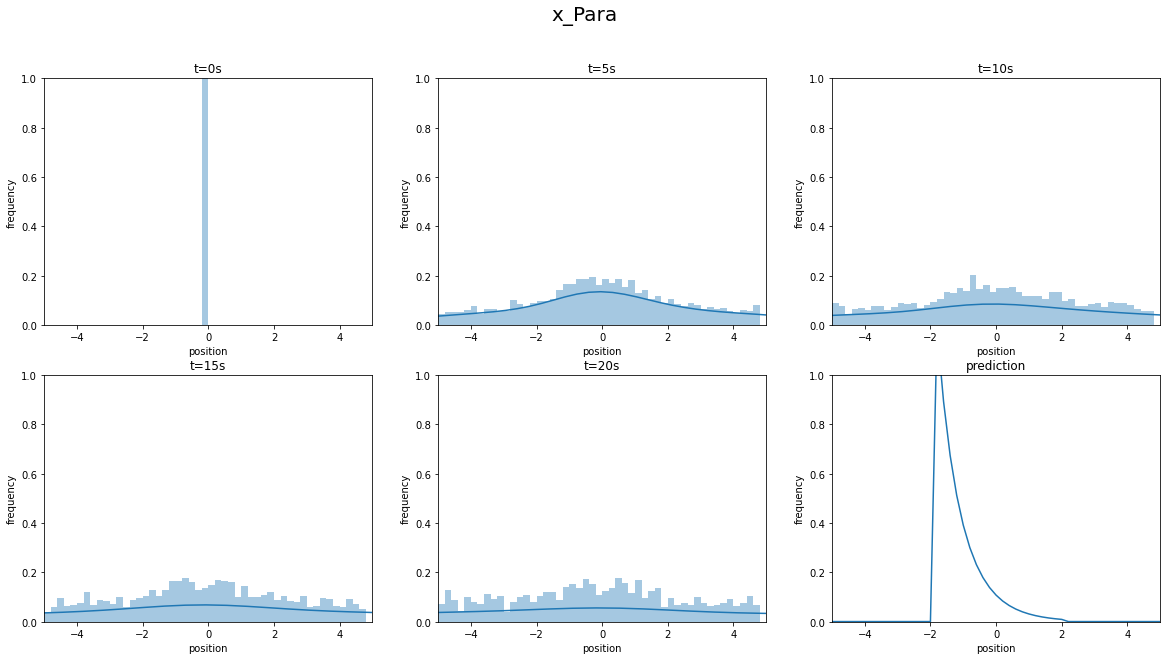

In [10]:
'''
dist_temp_t0  = np.hstack((x_Para[:,int(length*0.00) + i] for i in range(hist_range)))
dist_temp_t5  = np.hstack((x_Para[:,int(length*0.25) + i] for i in range(hist_range)))
dist_temp_t10 = np.hstack((x_Para[:,int(length*0.50) + i] for i in range(hist_range)))
dist_temp_t15 = np.hstack((x_Para[:,int(length*0.75) + i] for i in range(hist_range)))
dist_temp_t20 = np.hstack((x_Para[:,int(length*1.00 - hist_range) + i] for i in range(hist_range)))
'''

dist_temp_t0  = x_Para[:,length_t0]
dist_temp_t5  = x_Para[:,length_t5]
dist_temp_t10 = x_Para[:,length_t10]
dist_temp_t15 = x_Para[:,length_t15]
dist_temp_t20 = x_Para[:,length_t20-1]

plt.rcParams["figure.figsize"] = (20,10)

fig, axs = plt.subplots(2,3)

for (m,n), subplot in np.ndenumerate(axs):
    subplot.set_xlim(-L, L)
    subplot.set_ylim(0, 1)
    axs[m,n].set(xlabel='position', ylabel='frequency')

sns.distplot(dist_temp_t0 , bins = np.arange(-5, 5, 0.2), norm_hist = True, kde = False ,ax = axs[0, 0])
axs[0, 0].set_title('t=0s')
sns.distplot(dist_temp_t5 , bins = np.arange(-5, 5, 0.2), norm_hist = True, kde = True , ax = axs[0, 1])
axs[0, 1].set_title('t=5s')
sns.distplot(dist_temp_t10, bins = np.arange(-5, 5, 0.2), norm_hist = True, kde = True , ax = axs[0, 2])
axs[0, 2].set_title('t=10s')
sns.distplot(dist_temp_t15, bins = np.arange(-5, 5, 0.2), norm_hist = True, kde = True , ax = axs[1, 0])
axs[1, 0].set_title('t=15s')
sns.distplot(dist_temp_t20, bins = np.arange(-5, 5, 0.2), norm_hist = True, kde = True , ax = axs[1, 1])
axs[1, 1].set_title('t=20s')
#subplot.set_ylim(0, 100) #for prediction plot only
axs[1, 2].plot(x_edges, pdf_predict) #p1_predict is oringinal, p2_predict is normalized???
axs[1, 2].set_title('prediction')

plt.suptitle('x_Para', size  = 20)

In [11]:
# 2D hist plot
# https://stackoverflow.com/questions/24523670/how-do-i-use-colorbar-with-hist2d-in-matplotlib-pyplot
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist2d.html
# https://matplotlib.org/3.1.1/gallery/axes_grid1/scatter_hist_locatable_axes.html#sphx-glr-gallery-axes-grid1-scatter-hist-locatable-axes-py

(-15.0, 15.0)

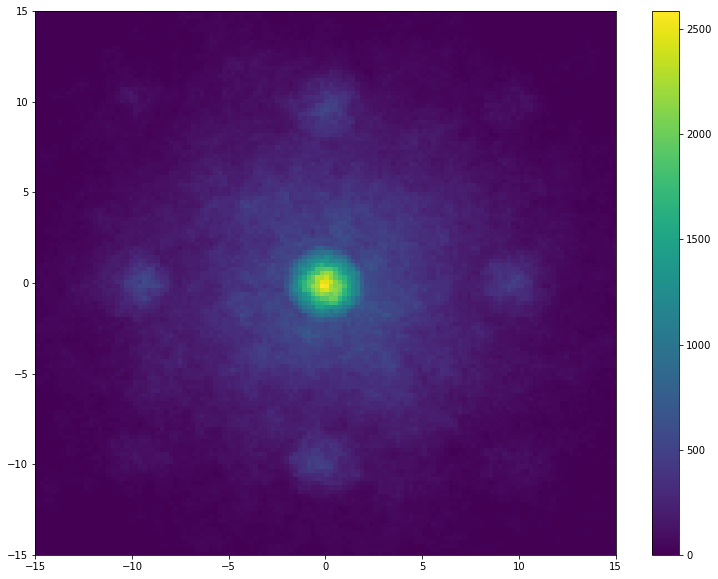

In [12]:
plt.rcParams["figure.figsize"] = (13,10)
h = plt.hist2d(np.reshape(x_Para[:, 2000:3000], -1), np.reshape(y_Para[:, 2000:3000], -1), bins = 200)
plt.colorbar(h[3])
plt.xlim(-15,15)
plt.ylim(-15,15)

# MSD

In [13]:
msd_all = np.zeros((test_number,length))
msd_mean = np.zeros(length)
msd_std = np.zeros(length)
for i in np.arange(test_number):
    msd = msd_fft(np.vstack((x_Para[i], y_Para[i])).T)
    msd_all[i] = msd
    # plt.plot(np.arange(len(msd)),msd)
# plt.xlim(0, 500)
#plt.ylim(0, 20)
# plt.legend(np.arange(test_number), loc = 1, bbox_to_anchor = (1.05, 1))
#plt.title("x_Para")

In [14]:
for n in range(length):
    msd_mean[n] = np.mean(msd_all[:,n])
    msd_std[n] = np.std(msd_all[:,n])

In [15]:
#std
# msd_std = np.std(msd_all, axis = 1)
# skip the for loop

In [16]:
msd_std

array([2.74078532e-14, 1.80539810e-03, 3.66669542e-03, ...,
       1.36078836e+02, 1.36164249e+02, 1.36287717e+02])

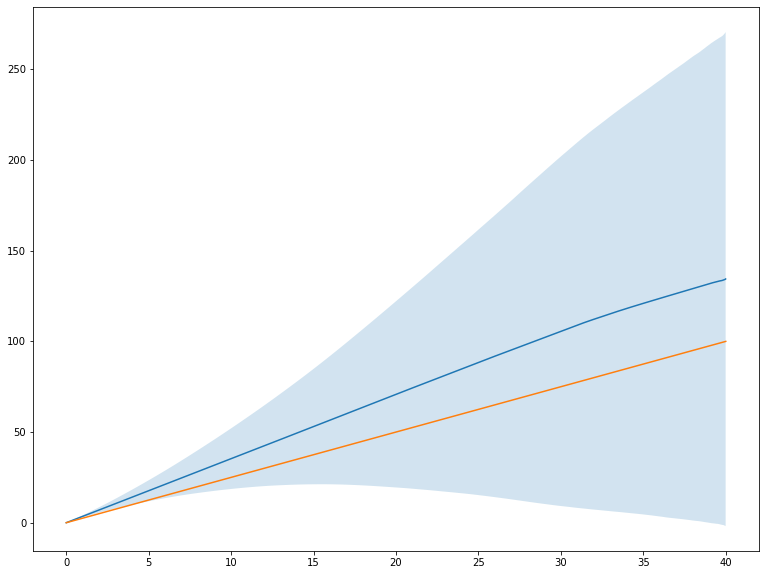

In [17]:
#plt.plot(np.arange(len(msd_mean))*dt,msd_mean)
plt.plot(t,msd_mean)
#plt.xlim(0, 5)
#plt.ylim(0, 10)
plt.plot((0,length*dt),(0,length/50)) #2000,40
plt.fill_between(t, msd_mean+msd_std, msd_mean-msd_std, alpha = 0.2)

In [18]:
# https://stackoverflow.com/questions/9538525/calculating-slopes-in-numpy-or-scipy
# https://math.stackexchange.com/questions/2565098/vector-notation-for-the-slope-of-a-line-using-simple-regression/2642719#2642719

msd_mean_lr_x = np.arange(len(msd_mean)) - np.mean(np.arange(len(msd_mean)))
msd_mean_lr_y = msd_mean - np.mean(msd_mean)
slope = (msd_mean_lr_x.dot(msd_mean_lr_y)) / (msd_mean_lr_x.dot(msd_mean_lr_x))

In [19]:
slope

0.027501074583971497

Text(0.5, 1.0, 'x_Para_plot')

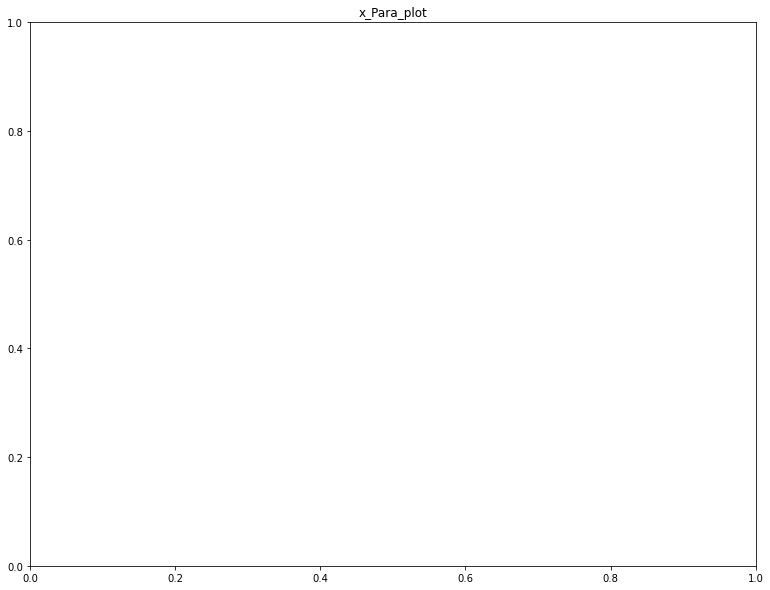

In [20]:
msd_all = np.zeros((test_number,length))
msd_mean = np.zeros(length)
for i in np.arange(test_number):
    msd = msd_fft(np.vstack((x_Para_plot[i], y_Para_plot[i])).T)
    msd_all[i] = msd
    # plt.plot(np.arange(len(msd)),msd)
# plt.xlim(0, 500)
#plt.ylim(0, 20)
# plt.legend(np.arange(test_number), loc = 1, bbox_to_anchor = (1.05, 1))
plt.title("x_Para_plot")

In [21]:
for n in range(length):
    msd_mean[n] = np.mean(msd_all[:,n])

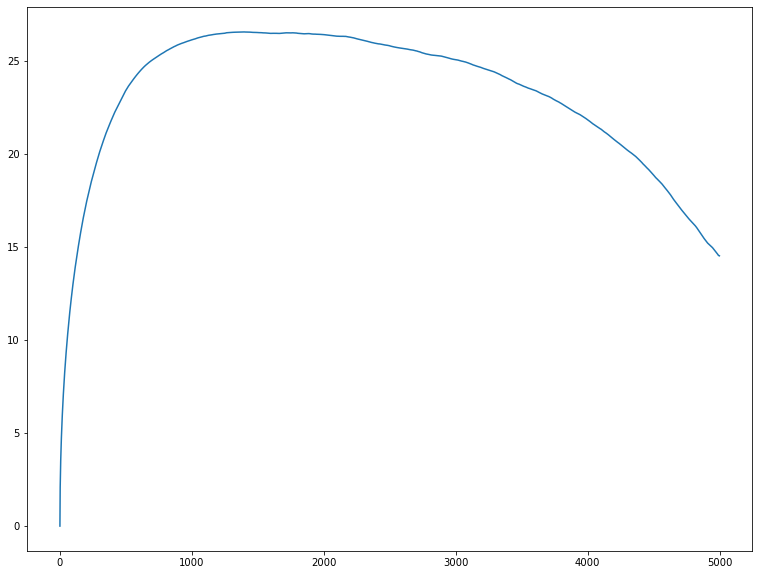

In [22]:
plt.plot(np.arange(len(msd_mean)),msd_mean)
#plt.xlim(0, 500)
#plt.ylim(0, 20)

In [23]:
msd_mean_lr_x = np.arange(len(msd_mean[0:300])) - np.mean(np.arange(len(msd_mean[0:300])))
msd_mean_lr_y = msd_mean[0:300] - np.mean(msd_mean[0:300])
slope = (msd_mean_lr_x.dot(msd_mean_lr_y)) / (msd_mean_lr_x.dot(msd_mean_lr_x))

In [24]:
slope

0.050212689334463295